Logbook:
https://docs.google.com/document/d/10F1qXnhcWOobazE5PRGmF3VUbtTOQDvJnlBE9xEdjEs/edit

TODO: Figure out how to scatter data. Most of the calculation time is transferring the data

# imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from glob import glob
from os.path import basename, exists
from tiffile import imread
import laserbeamsize as lbs
import matplotlib as mpl
import re
import xarray as xr
import dask.array as da
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, progress
import sys
import multiprocessing as mp
from scipy.ndimage import gaussian_filter1d
from glob import glob
mpl.rcParams['font.size'] = 20

# single file test

In [13]:
file = '../data/200.0K.h5'
ds = xr.open_dataset(file)
temp = ds.attrs['temperature']
ds

<xarray.Dataset>
Dimensions:      (time: 2048, row: 1340, col: 1300)
Coordinates:
  * time         (time) int32 0 1 2 3 4 5 6 ... 2042 2043 2044 2045 2046 2047
  * row          (row) int32 0 1 2 3 4 5 6 ... 1334 1335 1336 1337 1338 1339
  * col          (col) int32 0 1 2 3 4 5 6 ... 1294 1295 1296 1297 1298 1299
Data variables:
    image_stack  (time, row, col) float32 ...
Attributes:
    temperature:  200.0

## show images

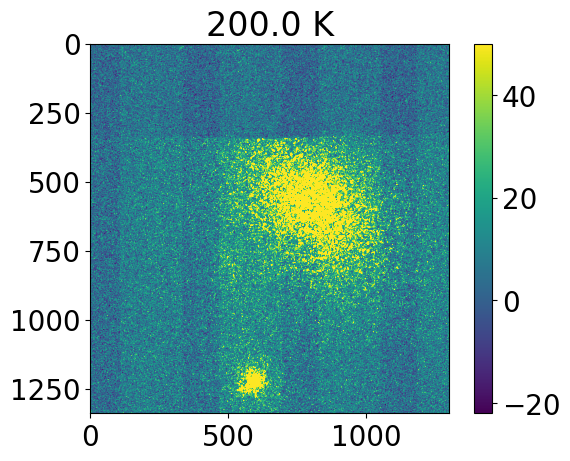

In [3]:
img = ds['image_stack'][1].compute().to_numpy()
plt.figure()
plt.title(f'{ds.attrs["temperature"]} K')
plt.imshow(img, vmin=np.percentile(img, 10), vmax=np.percentile(img, 90))
plt.colorbar()
plt.show()

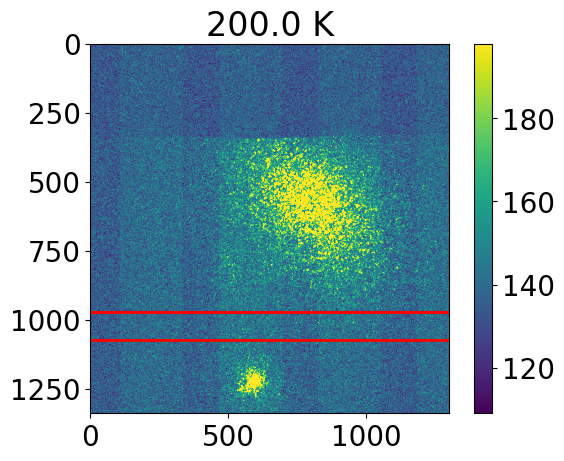

In [4]:
roi = np.s_[975:1075, ...]
overlay = np.zeros_like(img)
overlay[roi] = 1

img = ds['image_stack'][1].compute().to_numpy()
if np.amin(img) < 0:
    img += abs(np.amin(img))
plt.figure()
plt.title(f'{ds.attrs["temperature"]} K')
plt.imshow(img, vmin=np.percentile(img, 10), vmax=np.percentile(img, 95))
plt.colorbar()
plt.contour(overlay, colors=['r'])
plt.show()

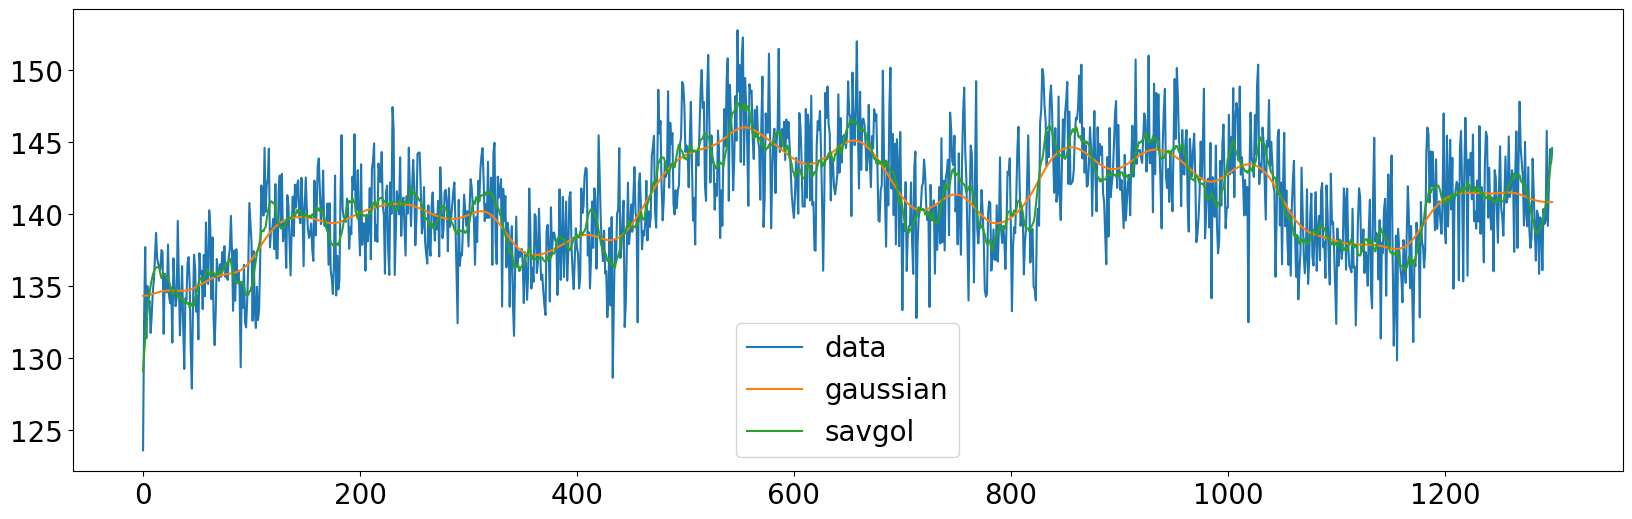

In [5]:
from scipy.signal import savgol_filter

line = img[roi].mean(axis=0)
gline = gaussian_filter1d(line, sigma=15)
sline = savgol_filter(line, window_length=31, polyorder=3)
plt.figure(figsize=(20,6))
plt.plot(line, label='data')
plt.plot(gline, label='gaussian')
plt.plot(sline, label='savgol')
plt.legend()
plt.show()

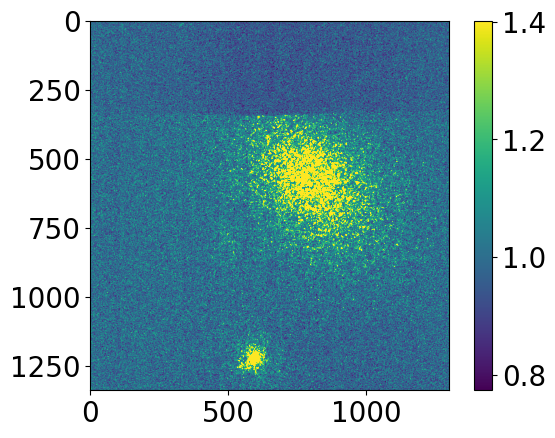

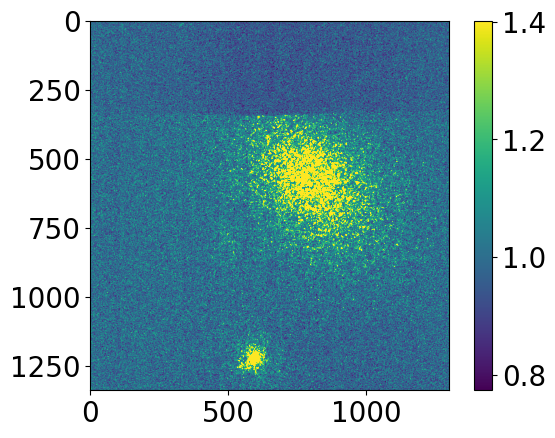

In [6]:
gimg = img / np.expand_dims(gline, axis=0)
simg = img / np.expand_dims(gline, axis=0)
plt.figure()
plt.imshow(gimg, vmin=np.percentile(gimg, 10), vmax=np.percentile(gimg, 95))
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(simg, vmin=np.percentile(simg, 10), vmax=np.percentile(simg, 95))
plt.colorbar()
plt.show()

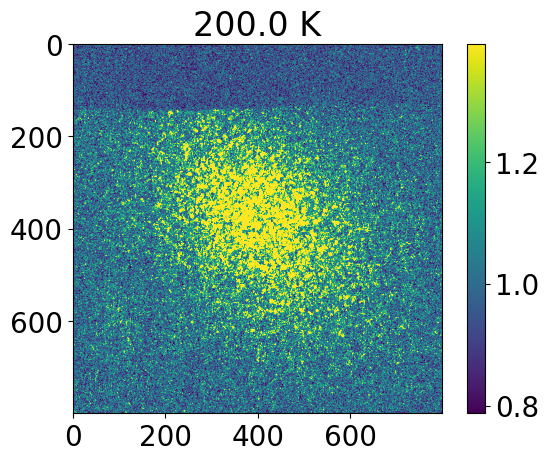

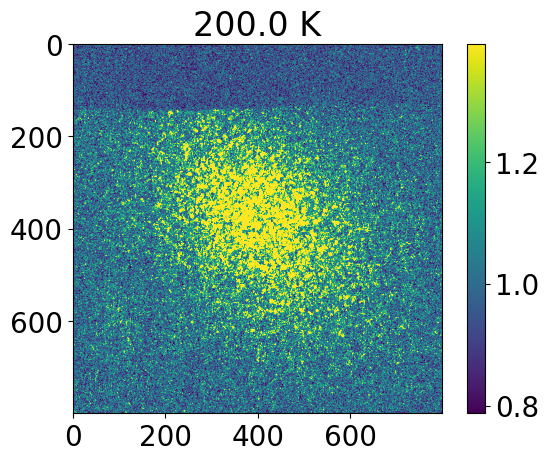

In [7]:
reduction_roi = np.s_[200:1000, 400:1200]
im = gimg[reduction_roi]

plt.figure()
plt.title(f'{ds.attrs["temperature"]} K')
plt.imshow(im, vmin=np.percentile(im, 10), vmax=np.percentile( im, 90))
plt.colorbar()
plt.show()

im = simg[reduction_roi]

plt.figure()
plt.title(f'{ds.attrs["temperature"]} K')
plt.imshow(im, vmin=np.percentile(im, 10), vmax=np.percentile( im, 90))
plt.colorbar()
plt.show()

In [8]:
img_stack = ds.chunk({'time':100, 'row': 1340, 'col':1300})['image_stack']
img_stack

<xarray.DataArray 'image_stack' (time: 2048, row: 1340, col: 1300)>
dask.array<xarray-image_stack, shape=(2048, 1340, 1300), dtype=float32, chunksize=(100, 1340, 1300), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int32 0 1 2 3 4 5 6 7 ... 2041 2042 2043 2044 2045 2046 2047
  * row      (row) int32 0 1 2 3 4 5 6 7 ... 1333 1334 1335 1336 1337 1338 1339
  * col      (col) int32 0 1 2 3 4 5 6 7 ... 1293 1294 1295 1296 1297 1298 1299

In [9]:
client = Client(n_workers=mp.cpu_count())
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 12,Total memory: 15.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61390,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.84 GiB
Comm: tcp://127.0.0.1:61448,Total threads: 1
Dashboard: http://127.0.0.1:61462/status,Memory: 1.32 GiB
Nanny: tcp://127.0.0.1:61393,


In [11]:
filter_roi = np.s_[975:1075, ...]
reduction_roi = np.s_[200:1000, 400:1200]
lines = img_stack[(..., *filter_roi)].mean(axis=1)
glines = gaussian_filter1d(lines,  sigma=15, axis=1)
gimgs = img_stack[(..., *reduction_roi)] / np.expand_dims(glines[(..., reduction_roi[-1])], axis=(1))
smd = gimgs.compute()
smd


<xarray.DataArray 'image_stack' (time: 2048, row: 800, col: 800)>
array([[[ 0.921313  ,  0.8464884 ,  1.039743  , ...,  0.92539066,
          0.9490663 ,  0.9387252 ],
        [ 1.0041276 ,  1.1458563 ,  1.2147491 , ...,  0.92539066,
          0.93979204,  1.0190109 ],
        [ 0.83849835,  0.99101084,  1.0294484 , ...,  0.92539066,
          0.9737976 ,  0.9479889 ],
        ...,
        [ 0.73498005,  0.701966  ,  0.9882705 , ...,  0.8789664 ,
          1.0510832 ,  1.0035714 ],
        [ 0.8281465 ,  1.1252102 ,  1.0912154 , ...,  1.0677584 ,
          1.1438258 ,  0.944901  ],
        [ 0.8902575 ,  0.96004176,  0.9882705 , ...,  1.0894232 ,
          0.99234617,  1.04989   ]],

       [[ 2.5630481 ,  2.6876936 , -3.4819763 , ...,  0.7079628 ,
         -0.90496284, -0.70009345],
        [-3.3724318 ,  0.6719234 , -1.607066  , ..., -0.9102379 ,
          1.1060656 ,  3.700494  ],
        [ 9.173015  ,  0.        , -0.26784432, ..., -2.932989  ,
          0.30165428,  2.4003205 ],
...
        [ 3.3131316 ,  2.2489336 ,  1.9808625 , ...,  2.8802428 ,
          0.5731443 ,  0.9369467 ],
        [ 1.0602021 ,  1.9402564 ,  2.8612459 , ..., -0.28802428,
         -0.5731443 ,  1.9961039 ],
        [ 0.88350177,  0.1322902 ,  1.8047858 , ...,  0.4937559 ,
          0.5322054 ,  2.4849455 ]],

       [[ 1.2726588 ,  0.26163355,  2.3885818 , ...,  1.2624772 ,
         -0.22969194,  0.68939036],
        [ 0.29944912,  1.0465342 , -1.1196477 , ...,  0.61211014,
          0.9953317 ,  1.570278  ],
        [ 1.1229342 ,  0.8596531 ,  0.03732159, ...,  1.9511012 ,
          0.49766585,  1.3404813 ],
        ...,
        [ 1.8341259 ,  1.1586629 ,  2.201974  , ...,  1.0329359 ,
          1.1484597 ,  0.53619254],
        [ 0.33688027,  1.9809397 ,  3.6948376 , ...,  1.0329359 ,
          0.6125118 ,  1.2638824 ],
        [ 0.29944912,  1.9435636 ,  2.201974  , ...,  1.9511012 ,
          0.3062559 ,  1.6851765 ]]], dtype=float32)
Coordinates:
  * time     (time) int32 0 1 2 3 4 5 6 7 ... 2041 2042 2043 2044 2045 2046 2047
  * row      (row) int32 200 201 202 203 204 205 206 ... 994 995 996 997 998 999
  * col      (col) int32 400 401 402 403 404 405 ... 1195 1196 1197 1198 1199

In [15]:
out_file = f'../data/{temp}K_reduced.h5'
smd.to_netcdf(out_file, engine='h5netcdf')

# loop

In [2]:
client = Client(n_workers=mp.cpu_count())
client

c:\Users\rtumbleson\anaconda3\envs\general\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57725 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:57725/status,
Dashboard: http://127.0.0.1:57725/status,Workers: 12
Total threads: 12,Total memory: 15.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57726,Workers: 12
Dashboard: http://127.0.0.1:57725/status,Total threads: 12
Started: Just now,Total memory: 15.84 GiB
Comm: tcp://127.0.0.1:57798,Total threads: 1
Dashboard: http://127.0.0.1:57808/status,Memory: 1.32 GiB
Nanny: tcp://127.0.0.1:57729,


In [3]:
files = glob('../data/*K.h5')
files

['../data\\200.0K.h5',
 '../data\\225.0K.h5',
 '../data\\230.0K.h5',
 '../data\\230.5K.h5',
 '../data\\231.0K.h5',
 '../data\\231.1K.h5',
 '../data\\231.5K.h5',
 '../data\\232.0K.h5']

In [10]:
for file in tqdm(files):
    ds = xr.open_dataset(file)
    temp = ds.attrs['temperature']
    out_file = f'../data/{temp}K_reduced.h5'
    if exists(out_file):
            continue
    
    # show single image and reduction roi
    img = ds['image_stack'][1].compute().to_numpy()

    img_stack = ds.chunk({'time':100, 'row': 1340, 'col':1300})['image_stack']
    filter_roi = np.s_[975:1075, ...]
    reduction_roi = np.s_[200:1000, 400:1200]
    lines = img_stack[(..., *filter_roi)].mean(axis=1)
    glines = gaussian_filter1d(lines,  sigma=15, axis=1)
    gimgs = img_stack[(..., *reduction_roi)] / np.expand_dims(glines[(..., reduction_roi[-1])], axis=(1))
    smd = gimgs.compute()
    

    fig, ax = plt.subplots(ncols=2)
    plt.suptitle(f'{temp:.1f} K')
    ax[0].imshow(img, vmin=np.percentile(img, 10), vmax=np.percentile(img, 95))
    ax[0].set_title('original')
    ax[1].imshow(smd[1], vmin=np.percentile(smd[1], 10), vmax=np.percentile(smd[1], 95))
    ax[1].set_title('reduced')
    plt.show()

    smd.to_netcdf(out_file, engine='h5netcdf')
    



  0%|          | 0/8 [00:00<?, ?it/s]